In [4]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

import matplotlib.pyplot as plt
%pylab inline
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

# create English stop words list
en_stop = set(stopwords.words('english'))

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
# create documents
depression_set = []
for i in xrange(781):
    f = open('depress_corpus/corpus_'+str(i))
    line = ""
    for j in f:
        line += j.decode('utf-8')
    depression_set.append(line)
    f.close()
control_set = []
for i in xrange(824):
    f = open('other_corpus/corpus_'+str(i))
    line = ""
    for j in f:
        line += j.decode('utf-8')
    control_set.append(line)
    f.close()
doc_set = depression_set + control_set
label = [1]*781 + [0]*824

In [6]:
# list for tokenized documents in loop
texts = []
# loop through document list
for i in doc_set:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop and len(i)>2]
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    # add tokens to list
    texts.append(stemmed_tokens)
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
dictionary.save('BoW.dict')
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [8]:
from scipy.sparse import csr_matrix
data = []
row = []
col = []
for (N,c) in enumerate(corpus):
    for i in c:
        data.append(i[1])
        row.append(N)
        col.append(i[0])
BoW_feature = csr_matrix((data,(row,col))).toarray()

In [10]:
TOPIC = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=TOPIC, id2word = dictionary, passes = 10,iterations = 100)
ldamodel.save('lda20.model')

In [13]:
doc_lda = ldamodel[corpus]
data = []
row = []
col = []
for (N,doc) in enumerate(doc_lda):
    for i in doc:
        data.append(i[1])
        row.append(N)
        col.append(i[0])
LDA_feature = csr_matrix((data,(row,col))).toarray()

In [14]:
print BoW_feature.shape
print LDA_feature.shape

(1605, 8776)
(1605, 20)


In [82]:
numpy.save('bow_feature.npy',BoW_feature)
numpy.save('lda_feature.npy',LDA_feature)

In [31]:
from random import shuffle
label = numpy.array(label)
whole_feature = numpy.hstack((BoW_feature,LDA_feature))
random_index = range(BoW_feature.shape[0])

In [80]:
from sklearn.linear_model import LogisticRegression
lda = []
bow = []
whole = []
model = LogisticRegression(C = 0.1)
shuffle(random_index)
cross_num = int(len(random_index)/10.0)
for i in xrange(10):
    if i == 0:
        train_label = random_index[(cross_num * (i+1)):]
    else:
        train_label = random_index[0:(cross_num * i)] + random_index[(cross_num * (i+1)):]
    test_label = random_index[(cross_num * i):(cross_num * (i+1))]
    model.fit(whole_feature[train_label],label[train_label])
    p = model.predict(whole_feature[test_label])
    whole.append(sum(label[test_label] == p)/float(len(p)))
    
    model.fit(BoW_feature[train_label],label[train_label])
    p = model.predict(BoW_feature[test_label])
    bow.append(sum(label[test_label] == p)/float(len(p)))
    
    model.fit(LDA_feature[train_label],label[train_label])
    p = model.predict(LDA_feature[test_label])
    lda.append(sum(label[test_label] == p)/float(len(p)))

0.8775


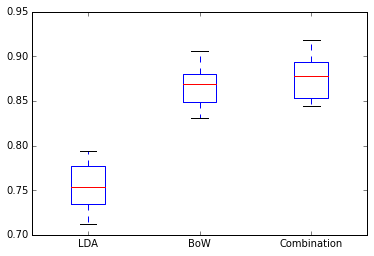

In [81]:
p = plt.boxplot((lda,bow,whole),labels=['LDA','BoW','Combination'])
print np.mean(whole)

In [85]:
from sklearn.externals import joblib
model.fit(whole_feature,label)
_ = joblib.dump(model, 'logistic_regression.model')

In [87]:
type(dictionary)

gensim.corpora.dictionary.Dictionary